In [2]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
# Variables
CSV_FILE = 'packet_features_data.csv'

In [4]:
# Read the dataset
df = pd.read_csv(CSV_FILE)

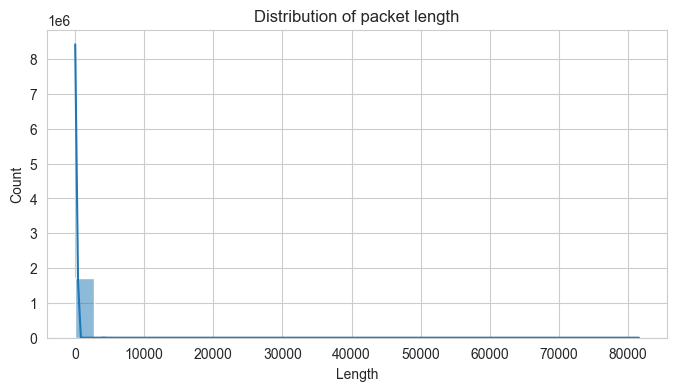

In [5]:
# HISTOGRAMS
plt.figure(figsize=(8,4))
sns.histplot(df['length'], bins=30, kde=True)
plt.title('Distribution of packet length')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

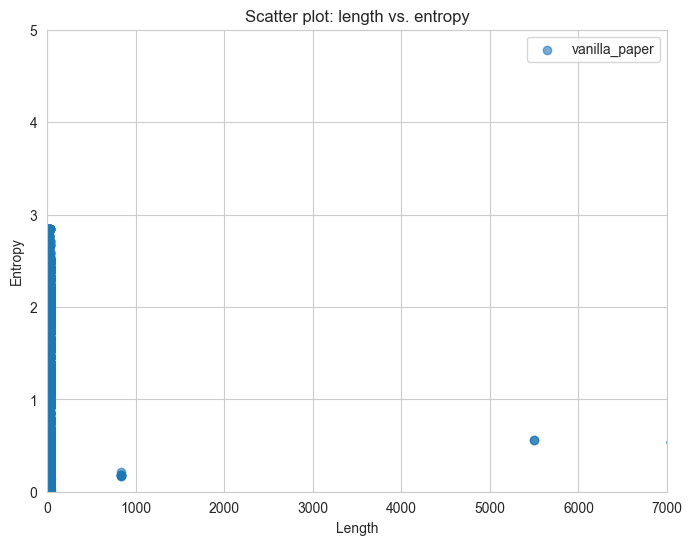

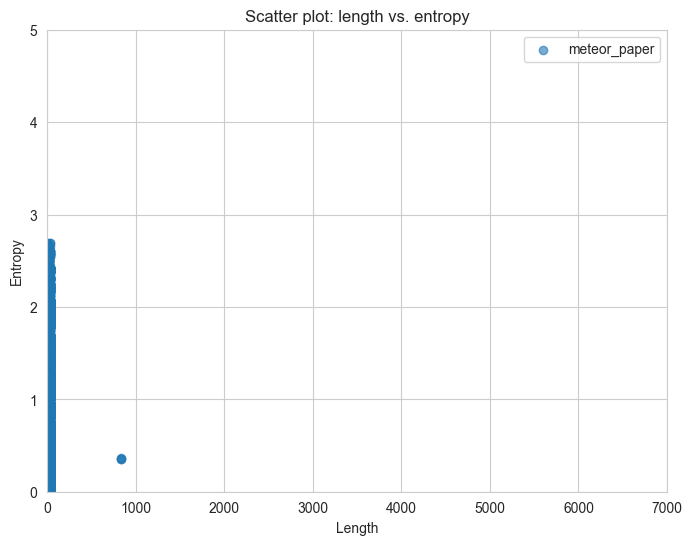

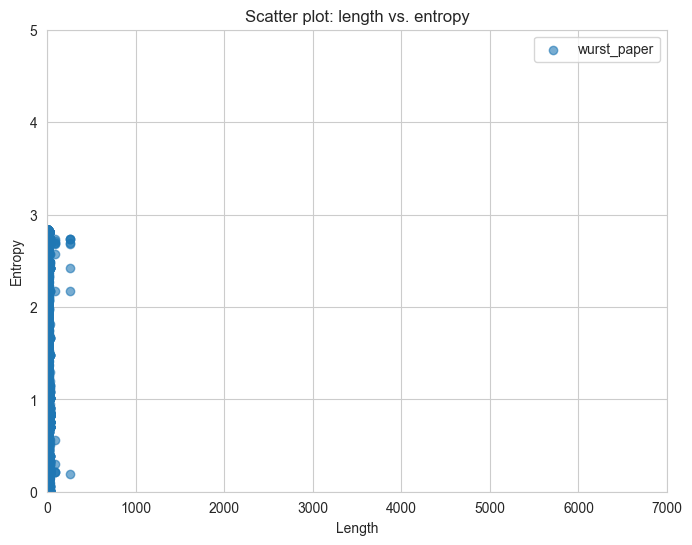

In [24]:
# Scatterplot
for label in df[df['direction'] == 'INCOMING']['label'].unique():
    plt.figure(figsize=(8,6))
    subset = df[(df['direction'] == 'INCOMING') & (df['label'] == label)]
    plt.scatter(subset['length'], subset['entropy'], label=label, alpha=0.6)
    plt.xlim(0, 7000)
    plt.ylim(0, 5)
    plt.title('Scatter plot: length vs. entropy')
    plt.xlabel('Length')
    plt.ylabel('Entropy')
    plt.legend()
    plt.show()

# sns.scatterplot(x='length', y='entropy', hue='label', data=df[df['direction'] == 'INCOMING'])


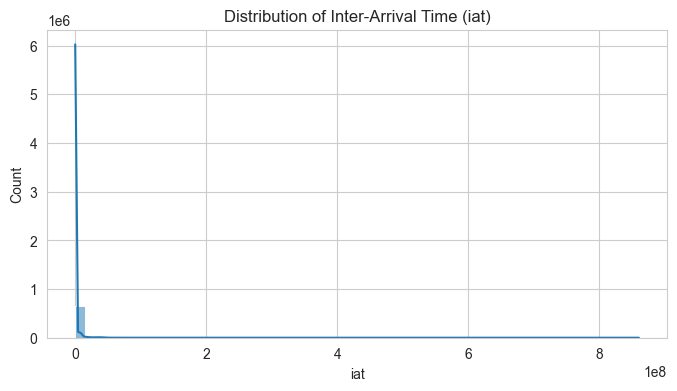

In [19]:
plt.figure(figsize=(8,4))
sns.histplot(df[df['direction'] == 'INCOMING']['iat'], bins=30, kde=True)
plt.title('Distribution of Inter-Arrival Time (iat)')
plt.xlabel('iat')
plt.ylabel('Count')
plt.show()

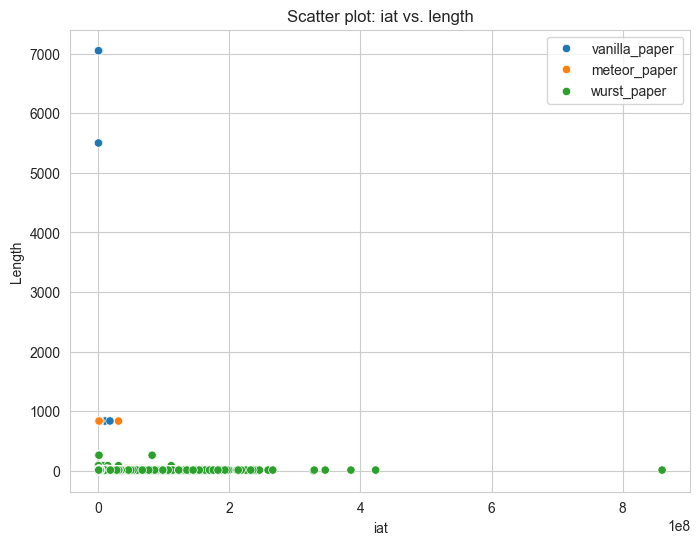

In [20]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='iat', y='length', hue='label', data=df[df['direction'] == 'INCOMING'])
plt.title('Scatter plot: iat vs. length')
plt.xlabel('iat')
plt.ylabel('Length')
plt.legend()
plt.show()

Absolute frequencies:
 label
wurst_paper      704449
vanilla_paper    509992
meteor_paper     503748
Name: count, dtype: int64

Relative frequencies:
 label
wurst_paper      0.409995
vanilla_paper    0.296820
meteor_paper     0.293185
Name: proportion, dtype: float64


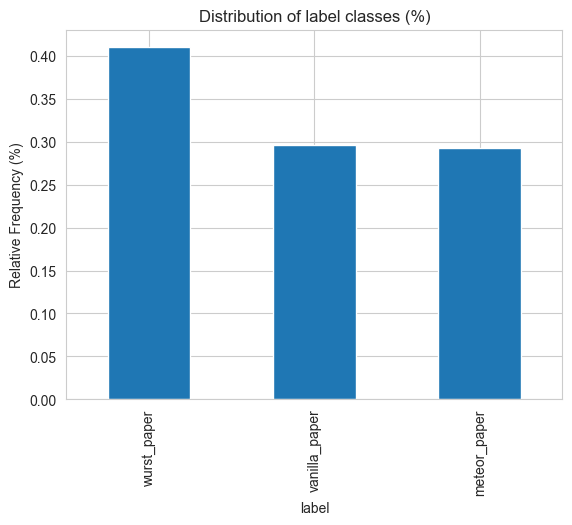

In [12]:
counts = df['label'].value_counts(dropna=False)
rel = df['label'].value_counts(normalize=True, dropna=False)
# Print absolute and relative frequencies
print("Absolute frequencies:\n", counts)
print("\nRelative frequencies:\n", rel)

# Plot absolute frequencies
rel.plot(kind='bar', title='Distribution of label classes (%)')
plt.ylabel('Relative Frequency (%)')
plt.show()

In [13]:
import math

# Shannon Entropy
n = len(df)
class_counts = counts.to_dict()
k = len(class_counts)
entropy = -sum((c/n) * math.log((c/n), 2) if c > 0 else 0 for c in class_counts.values())
max_ent = math.log(k, 2) if k > 1 else 1
balance = entropy / max_ent if max_ent > 0 else 0
print(f"Entropy = {entropy:.4f} bits, Balance Score (0 unbalanced ⇒ 1 fully balanced) = {balance:.4f}")

Entropy = 1.5665 bits, Balance Score (0 unbalanced ⇒ 1 fully balanced) = 0.9883


In [15]:
from collections import Counter
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 5. Model baseline with and without class weights
X = df.drop(columns=['label', 'clientId', 'packetId', 'timestamp'])
X = pd.get_dummies(X)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

clf = LogisticRegression(class_weight='balanced', max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("\nClassification report with class_weight='balanced':\n",
      classification_report(y_test, y_pred))
print("MCC:", matthews_corrcoef(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# 6. (Optional) Try SMOTE oversampling in case of strong imbalance
if balance < 0.6:
    print("\n>>> Attempt: SMOTE oversampling")
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    print("New class distribution:", Counter(y_res))
    clf2 = LogisticRegression(max_iter=1000)
    clf2.fit(X_res, y_res)
    y2 = clf2.predict(X_test)
    print("\nReport after SMOTE:\n", classification_report(y_test, y2))
    print("MCC after SMOTE:", matthews_corrcoef(y_test, y2))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Classification report with class_weight='balanced':
                precision    recall  f1-score   support

 meteor_paper       0.82      0.94      0.87    151124
vanilla_paper       1.00      0.98      0.99    152998
  wurst_paper       0.94      0.85      0.89    211335

     accuracy                           0.92    515457
    macro avg       0.92      0.92      0.92    515457
 weighted avg       0.92      0.92      0.92    515457

MCC: 0.8740294535289598
Confusion matrix:
 [[141692      0   9432]
 [     0 150244   2754]
 [ 31558      0 179777]]
